[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/DataImaging)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split


---
# Data preparation

## load data

In [2]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

## split the images from the labels

In [3]:
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

x_train = train_data[:, 1:] / 255
y_train = train_data[:, 0]

x_test = test_data[:, 1:] / 255
y_test = test_data[:, 0]

## split the training data into train and validate

In [4]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

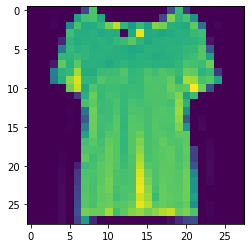